$$**Un-Supervised-Project**$$

$Buisness - Objective$
#### We have to create Customer cluster to identify the different types of customers. 
**Here we do not have any target variable so we have to perform unsupervised machine learning**

In [1]:
# Importing libraries

import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler # scaling the data
from sklearn import preprocessing
from sklearn.cluster import KMeans # k-mean model
from sklearn.metrics import silhouette_samples, silhouette_score # k-mean model
import matplotlib.cm as cm

from sklearn.decomposition import PCA # Principal Component analysis
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering  # BOTTOM UP APPRAOACH (hierarchical clustering)
from sklearn.cluster import DBSCAN # Density-Based Spatial Clustering of Applications with Noise Model

##### Uploading the file to google colab

In [2]:
# uploading the data
from google.colab import files
upload = files.upload()

Saving Proj3_MallCustomers_Data_Project.csv to Proj3_MallCustomers_Data_Project (4).csv


Read the data

In [3]:
import io
# raead the data
Mall_df = pd.read_csv(io.BytesIO(upload['Proj3_MallCustomers_Data_Project.csv']))

In [4]:
# create copy of the main dataframe
Eval_df = Mall_df.copy()

In [5]:
# first 2 rows
Mall_df.head(2)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81


In [6]:
# last 2 rows
Mall_df.tail(2)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
198,199,Male,32,137,18
199,200,Male,30,137,83


In [7]:
# shape of the data
Mall_df.shape

(200, 5)

In [8]:
# information about the data

Mall_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [9]:
# column names
Mall_df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [10]:
# describe the numerical columns
Mall_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [11]:
# describe the non-numerical columns

Mall_df.describe(include="object").T

,count,unique,top,freq
Gender,200,2,Female,112


In [12]:
# checking for missing values

Mall_df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [13]:
# Removing unwanted columns (unique valued column - no impact on the data)
Mall_df.drop("CustomerID",axis=1,inplace=True)

In [14]:
# checking for duplicate rows 

Mall_df.duplicated().sum() # no duplicate rows are present in the data

0

Data visualization (uni_variate)

In [15]:
# function to plot a boxplot and a histogram along the same scale.

def histogram_boxplot(data, feature, figsize=(8, 8), kde=False, bins=None) :

    f2, (ax_box2, ax_hist2)= plt.subplots(
        nrows=2,sharex=True, gridspec_kw={"height_ratios": (4.95, 8.95)}, 
                    figsize = figsize)

    sns.boxplot(
        data = data, x = feature, ax = ax_box2, showmeans = True, color="orange")
    
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"  
    )if bins else sns.histplot( 
        data=data, x=feature, kde=kde, ax=ax_hist2) 
    ax_hist2.axvline(data[feature].mean(), color="b", linestyle="-")
    ax_hist2.axvline( data[feature].median(), color="red", linestyle="-")
     # Adding median line in the hist plot

In [16]:
# function for bar plots for catagorical columns
def bar(df,i):
  plt.suptitle(i,size = 20)
  g = df[i].value_counts()
  h=pd.DataFrame({"ind":g.index,"value":g.values})
  plt.barh(h["ind"].values,h["value"].values,color = ["g","orange"])
  plt.show()

In [17]:
# piechart for categorical features

def pie(df,col):
  stats = df[col].value_counts()
  values = list(stats)
  names = list(map(lambda x : ''.join((str(x))),list(stats.index)))
  plt.pie(values,labels=names,autopct="%0.2f%%")
  plt.title(col)
  plt.show()

Histogram and box plot for numerical values

<Figure size 576x396 with 0 Axes>

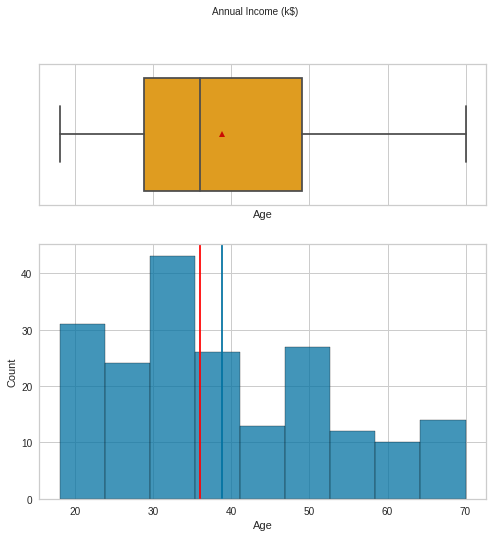

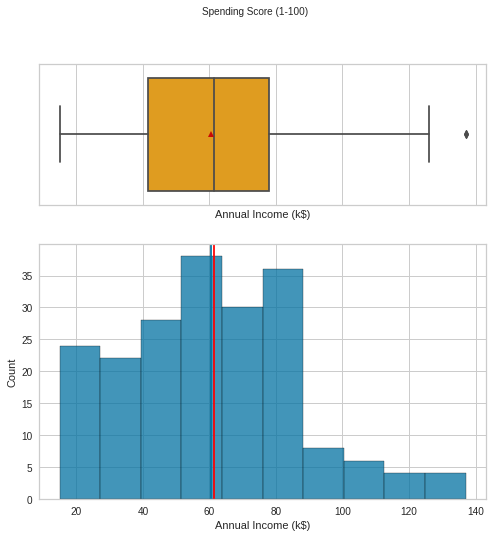

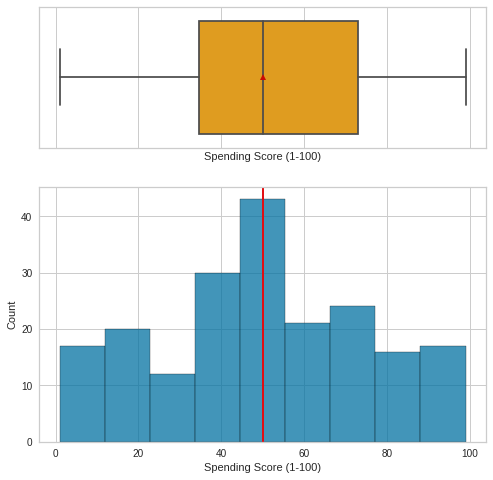

In [18]:
# Creating box plot and histogram for age column blue line represents  mean and redline repredents the median
numeric_col= Mall_df.select_dtypes("number").columns
for i in numeric_col:
  plt.suptitle(i,size = 10)
  histogram_boxplot(Mall_df,i)

There is one outliers in the annual income.

Outlier treatment

In [19]:
 # Function for outlier treatment

for col in numeric_col:

    quartile_3 = Mall_df[col].quantile(.75) 
    quartile_1 = Mall_df[col].quantile(.25)

    IQR = quartile_3 - quartile_1 # inter quartine range

    upper_f = quartile_3 + 1.5 * IQR

    lower_f = quartile_1 - 1.5 * IQR

    index1 = Mall_df[Mall_df [col]>upper_f]. index

    index2 = Mall_df[Mall_df [col]<lower_f].index
    
    Mall_df.loc[index1, col]=Mall_df[col].median()

    Mall_df.loc[index2, col]=Mall_df[col].median()

<Figure size 576x396 with 0 Axes>

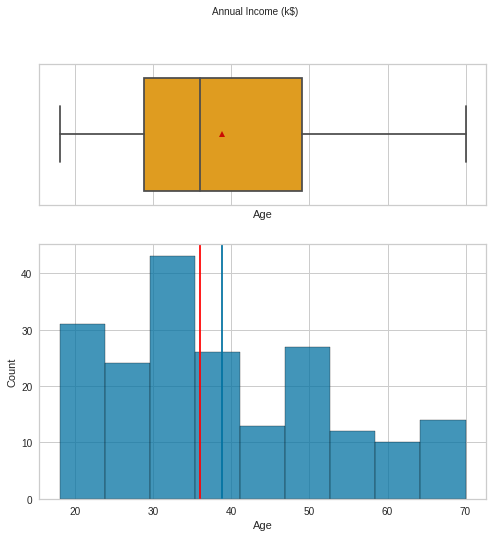

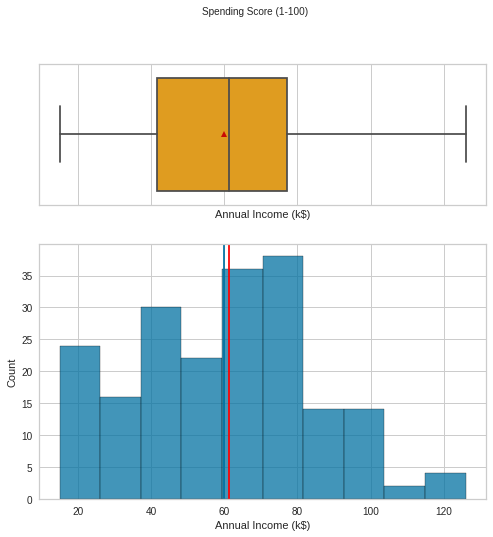

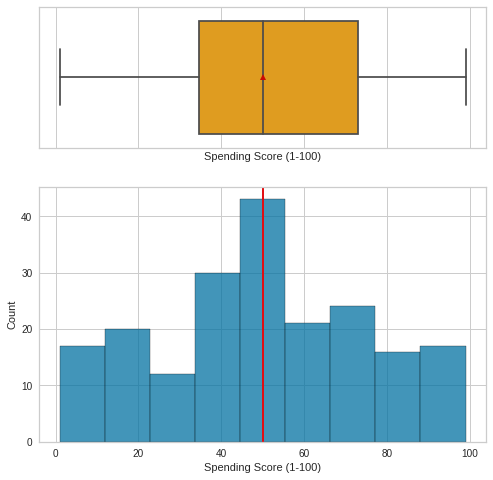

In [20]:
# Creating box plot and histogram for age column blue line represents  mean and redline repredents the median(after outlier treatment)
numeric_col= Mall_df.select_dtypes("number").columns
for i in numeric_col:
  plt.suptitle(i,size = 10)
  histogram_boxplot(Mall_df,i)

There are no outlier in the data ,for maximum features mean and median value are close to each other . 

Bar plots for catagorical columns

In [21]:
# categorical columns
cat_col= Mall_df.select_dtypes("object").columns
cat_col

Index(['Gender'], dtype='object')

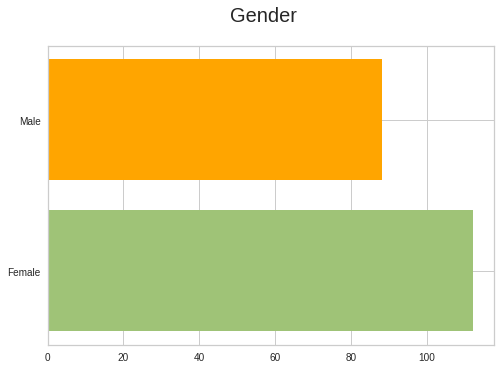

In [22]:
# barplots for all categorical columns

for i in cat_col:
  bar(Mall_df,i)

Pie charts for catagorical columns

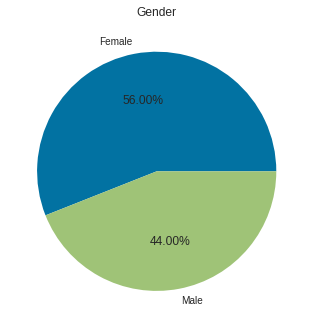

In [23]:
# piechart of all categorical feature

for i in cat_col:
  pie(Mall_df,i)

The percentage of Female(56%) customer is higher than the male(44%) customers .

##### Data visualization (Bi-variate)

In [24]:
# box plot
def visual_box(a,b,c):   # (a="other column" , b= "main column name",c="dataframe name")
    sns.boxplot(y = c[b], x = c[a],palette="husl")
    plt.show()

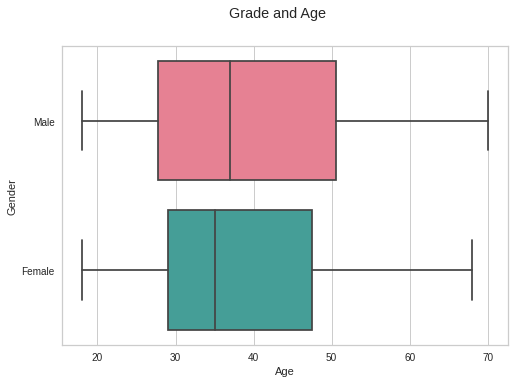

********************************************************************************


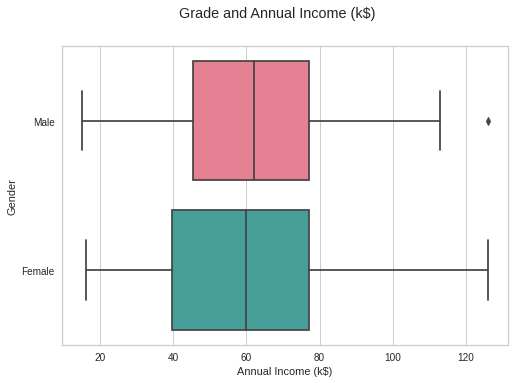

********************************************************************************


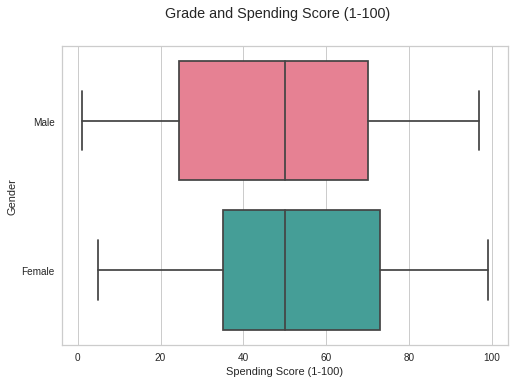

********************************************************************************


In [25]:
for i in numeric_col:
  for j in cat_col:
    plt.suptitle("Grade and "+str(i))
    visual_box(i,j,Mall_df)
    print(80*"*")

#### For male customers the range of spending score is higher than the female customers .
#### For male customers the average income is higher than female customers .
#### For male customers the average age and range of the age is higher than female customers .

Encoding for non numerical column

In [26]:
label_encoder = preprocessing.LabelEncoder()

# encoding the purpose variable

for i in cat_col:
  if type(Mall_df[i]=="object"):
    Mall_df[i]=label_encoder.fit_transform(Mall_df[i])

In [27]:
# first two rows

Mall_df.head(2)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15.0,39
1,1,21,15.0,81


In [28]:
# corelaation
corr=Mall_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Gender,Age,Annual Income (k$),Spending Score (1-100)
Gender,1.000000,0.060867,0.024997,-0.058109
Age,0.060867,1.000000,0.004013,-0.327227
Annual Income (k$),0.024997,0.004013,1.000000,0.010007
Spending Score (1-100),-0.058109,-0.327227,0.010007,1.000000


Gender and Annual Income (k$)  has weak corelation with other columns .
Age has weak neg corelation with Spending Score (1-100) .

In [29]:
Mall_df.sample (2)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
132,0,25,72.0,34
73,0,60,50.0,56


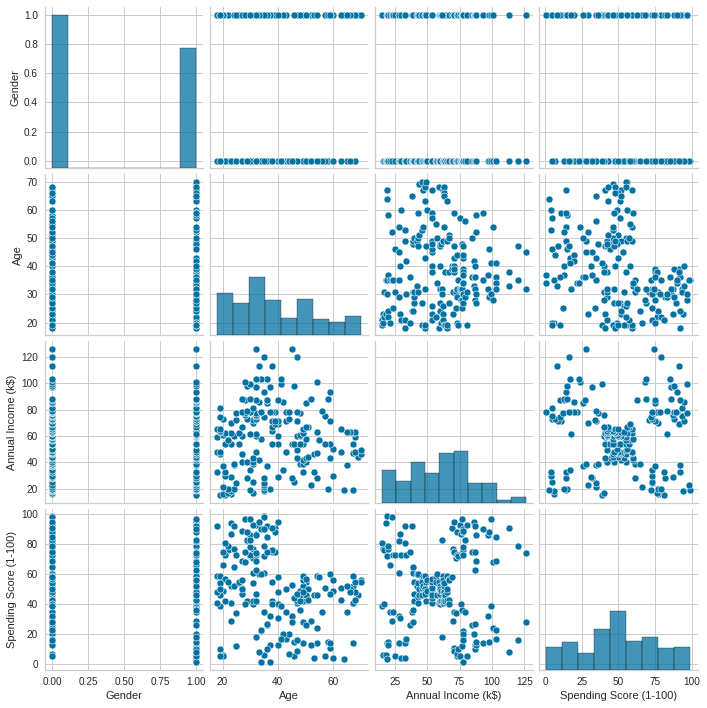

In [30]:
# creating scatterplots for all numerical collumns
sns.pairplot(Mall_df,palette="Dark2")
plt.show()

In [31]:
# selecting only mumerical columns
new_data = Mall_df.select_dtypes("number")

In [32]:
# first five rows
new_data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15.0,39
1,1,21,15.0,81
2,0,20,16.0,6
3,0,23,16.0,77
4,0,31,17.0,40


In [33]:
# Standardrizing data

sc = StandardScaler()
data_scaled=sc.fit_transform(new_data)

##### Unsupervised Machine Learning
* PCA

In [34]:
# # Explained variance ratio with number of component

var_ratio={}
for n in range(2,5):
    pc=PCA(n_components=n)
    data_pca=pc.fit(data_scaled)
    var_ratio[n]=sum(data_pca.explained_variance_ratio_)

var_ratio

{2: 0.5912313704389416, 3: 0.8318828383325895, 4: 1.0}

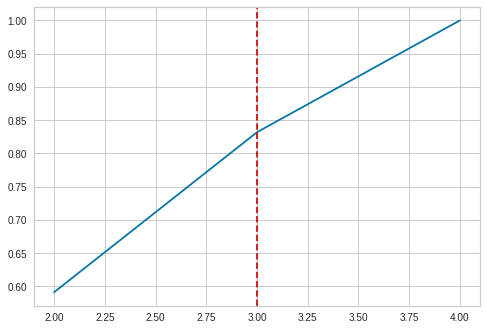

In [35]:
# Plotting explained variance ratio with number of component

pd.Series(var_ratio).plot()
plt.axvline(x=3, color='r', linestyle='--')
plt.show()

We can see there is a sudden drop in the graph when number of components =3 and 83.18% of the variance can explain by the three components .

In [36]:
# Fitting PCA on data data with 3 components
pc_final=PCA(n_components = 3).fit(data_scaled)

# creating reduced data
reduced_data = pc_final.fit_transform(data_scaled)

In [37]:
# Variance explained by each component- 
pd.Series(pc_final.explained_variance_ratio_, index=['PC_'+ str(i) for i in range(1,4)])

PC_1    0.336900
PC_2    0.254332
PC_3    0.240651
dtype: float64

#### First Two compoments explaining about of 59.92 % variance.

In [38]:
col_list=new_data.columns
pcdf = pd.DataFrame(pc_final.components_.T, columns=['PC_' +str(i) for i in range(1,4)], index=col_list)
pcdf 

,PC_1,PC_2,PC_3
Gender,0.235585,0.541254,-0.807174
Age,0.687729,-0.076836,0.145925
Annual Income (k$),0.005114,0.829418,0.557802
Spending Score (1-100),-0.686660,0.114920,-0.126625


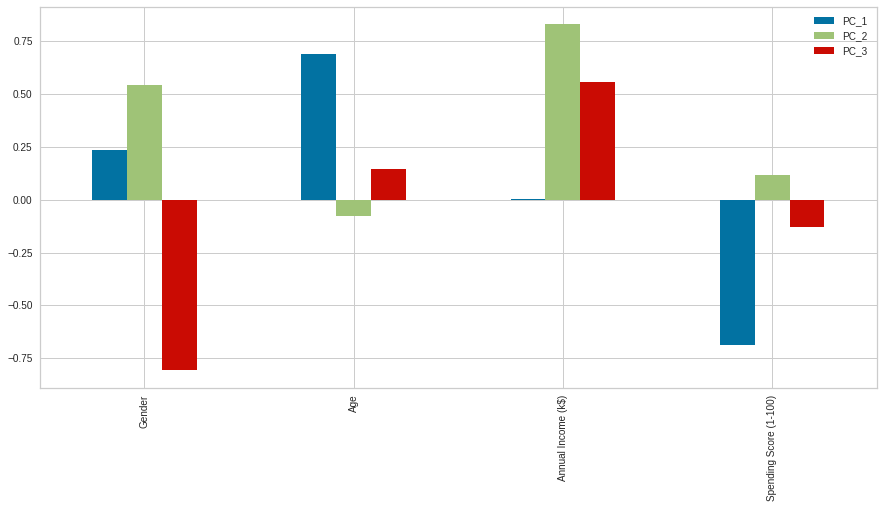

In [39]:
# ploting PC
pcdf.plot(kind = 'bar',figsize = (15,7))
plt.show()

### Observations from PCA

* First two compoments explaining 59.92 % variance.

* Component 1 -  Age  and Spending Score (1-100) have high value in component1.
              *  68.79 % of the mean value of age can explain by the first component .
              *  68.69 % of the mean value of Spending Score (1-100) can explain by the first component .
* Component 2 - Gender and Annual Income (k$) have high value in component2.
              *  62.68 %  mean values of Gender columns can explain by the second component .
              *  72.52 %  mean values of Annual Income (k$) columns can explain by the second component .

So, we can consider four variables (age ,Spending Score (1-100),Gender and Annual Income (k$).

#### K-Means Clustering

##### Selecting the value of K

 Elbow method

In [40]:
wss = []  # Within the sum of squares 

# Creating a cluster with range 2 to 8 and calculating cluster_errors
for k in range(2, 8):
    Kmeans_model = KMeans(n_clusters=k)
    Kmeans_model.fit(data_scaled)
    wss.append(Kmeans_model.inertia_)

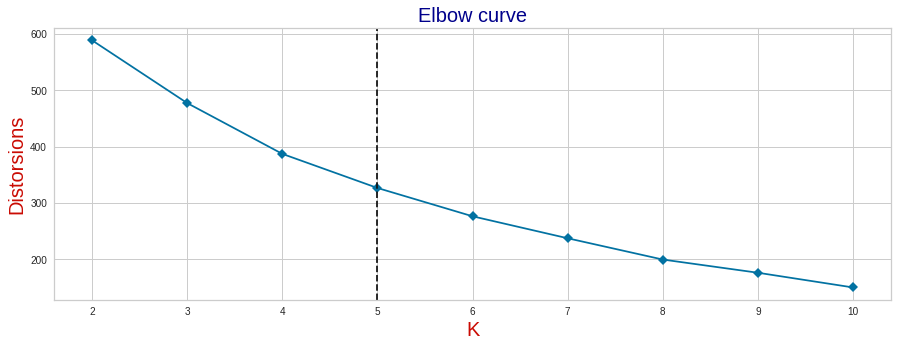

In [41]:
# creating line plot for finding best k vlue by using elbow curve

fig = plt.figure(figsize=(15, 5))
plt.grid(True)
KElbowVisualizer( Kmeans_model,timings=False,linewidth = 2 ).fit(data_scaled);
plt.xlabel('K',size = 20 , color = "r")
plt.ylabel('Distorsions',size = 20 , color = "r")
plt.title('Elbow curve',size =20,color = "darkblue");

By the above plot, we can see that there is a elbow at k=5.

Hence k=5 can be considered a good number of the cluster to cluster this data.

We will further use Silhouette Coefficient method to validate value of K.

Silhouette Coefficient method

For n_clusters = 2 The average silhouette_score is : 0.2506458122602306
For n_clusters = 3 The average silhouette_score is : 0.25775456569214666
For n_clusters = 4 The average silhouette_score is : 0.30042129922580796
For n_clusters = 5 The average silhouette_score is : 0.3175072460234204
For n_clusters = 6 The average silhouette_score is : 0.3252619985260698


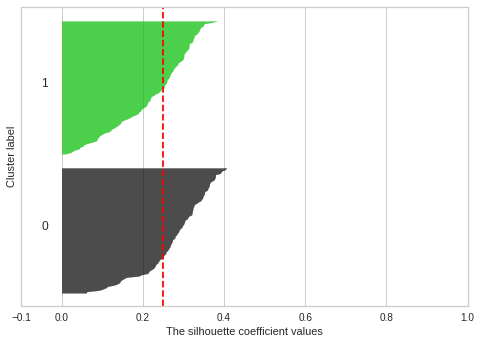

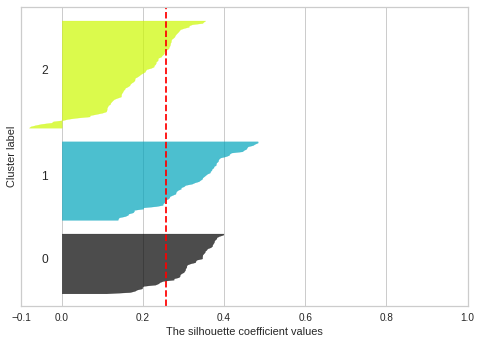

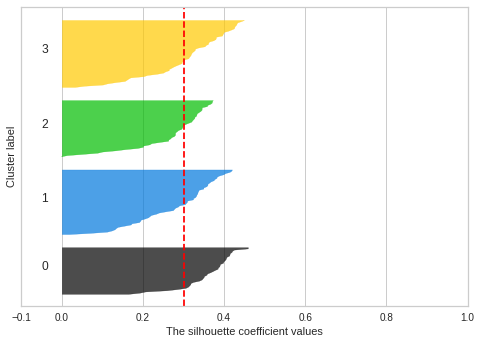

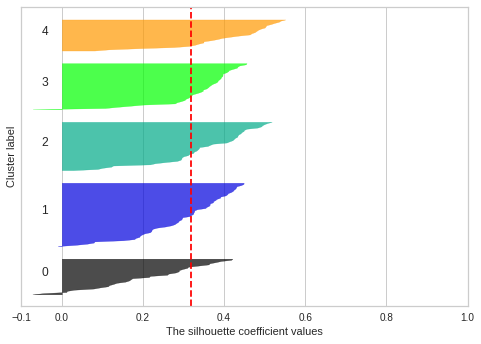

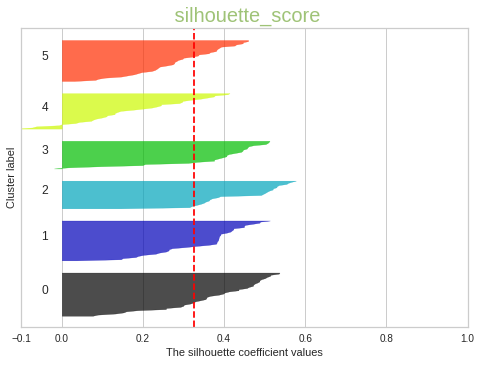

In [42]:
X  = data_scaled
range_n_clusters = np.arange(2,7)

for n_clusters in range_n_clusters:
 # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1, 1)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
    "The average silhouette_score is :", silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
        0, ith_cluster_silhouette_values,
        facecolor=color, edgecolor=color, alpha=0.7)
         # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
         # Compute the new y_lower for next plot
        y_lower = y_upper + 10 # 10 for the 0 samples
    
    
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([]) # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.title(' silhouette_score',size =20,color = "g");

 We find from silhouette the value of K=6 is the optimum value .when number of clusters = 6 The average silhouette_score is : 0.3252619985260698. So we consider number of cluster=6

### Model for K_Mean Clustering

In [43]:
# creating model(K_mean)

Kmeans_model_1 = KMeans(n_clusters = 6)
Kmeans_model_1.fit(data_scaled)

KMeans(n_clusters=6)

In [44]:
# calculating labels where k = 6 

labels_1 = Kmeans_model_1.labels_

1    40
4    39
2    37
3    31
5    30
0    23
dtype: int64


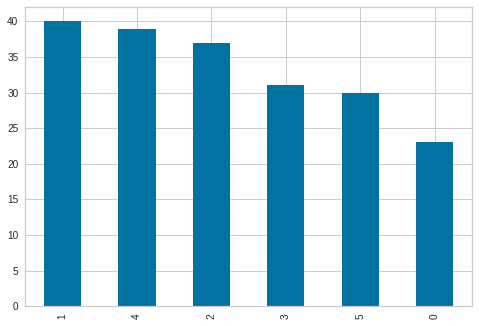

In [45]:
# Number of observations in each cluster
print(pd.Series(Kmeans_model_1.labels_).value_counts())
pd.Series(Kmeans_model_1.labels_).value_counts().plot( kind= 'bar')
plt.show()

* First cluster we have 28 rows based on their symmetry .
* Second cluster we have 41 rows based on their symmetry .
* Third cluster we have 38 rows based on their symmetry .
* Fourth cluster we have 24 rows based on their symmetry .
* Fifth cluster we have 32 rows based on their symmetry .
* sixth cluster we have 37 rows based on their symmetry .

In [46]:
gg = Mall_df.loc[:,["Annual Income (k$)","Spending Score (1-100)"]]

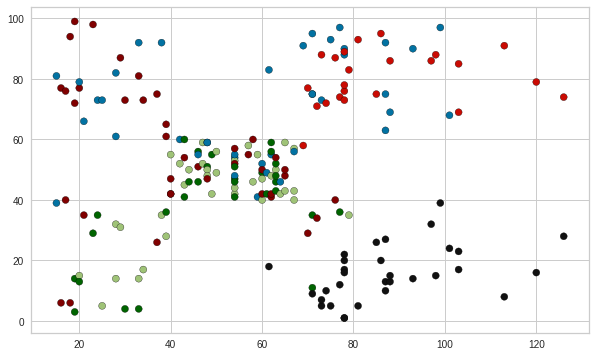

In [47]:
# plotting 6 clusters
s = gg.loc[:,"Annual Income (k$)"]
f = gg.loc[:,"Spending Score (1-100)"]
color_map={0:'r',1:'b',2:'g',3:'k',4:"maroon",5:"darkgreen"}
label_color=[color_map[l] for l in Kmeans_model_1.labels_]
plt.figure(figsize=(10,6))
plt.scatter(s,f, c=label_color ,cmap='Spectral',edgecolors = "black")
plt.show()

Above scatter plot shows all 6 clusters are clearly seprating the data .

##### create a pair plot

In [48]:
# Adding cluster labels with PCA data 
df_pair_plot=pd.DataFrame(reduced_data, columns=['PC_' +str(i) for i in range(1,4)])
df_pair_plot['Cluster1']=Kmeans_model_1.labels_
df_pair_plot.head()

,PC_1,PC_2,PC_3,Cluster1
0,-0.424529,-0.813534,-2.061221,1
1,-1.445420,-0.637185,-2.246739,1
2,0.030119,-2.023548,-0.240160,4
3,-1.714475,-1.723334,-0.557763,4
4,-0.333106,-1.899405,-0.269829,4


#### Pair plot

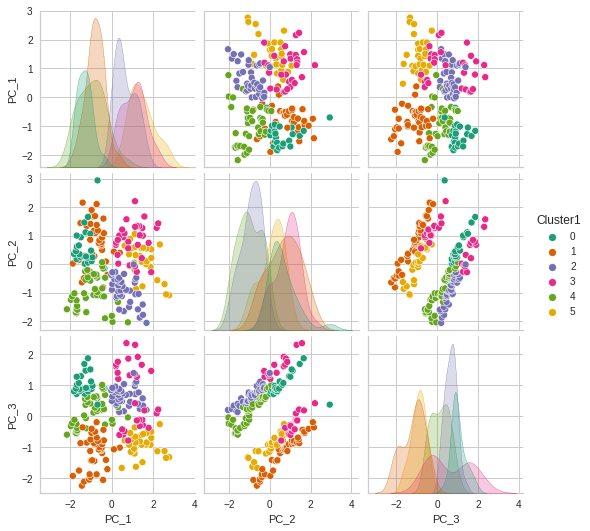

In [49]:
# pair wise relationship of components on the data
sns.pairplot(df_pair_plot, hue='Cluster1', palette= 'Dark2', diag_kind='kde')
plt.show()

#### Above pair plot shows,PC2 and PC1 have better sepration of all clusters.

### Agglomerative hierarchical clustering
##### Compute the Dendogram to choose the number of clusters with threshold cut value .

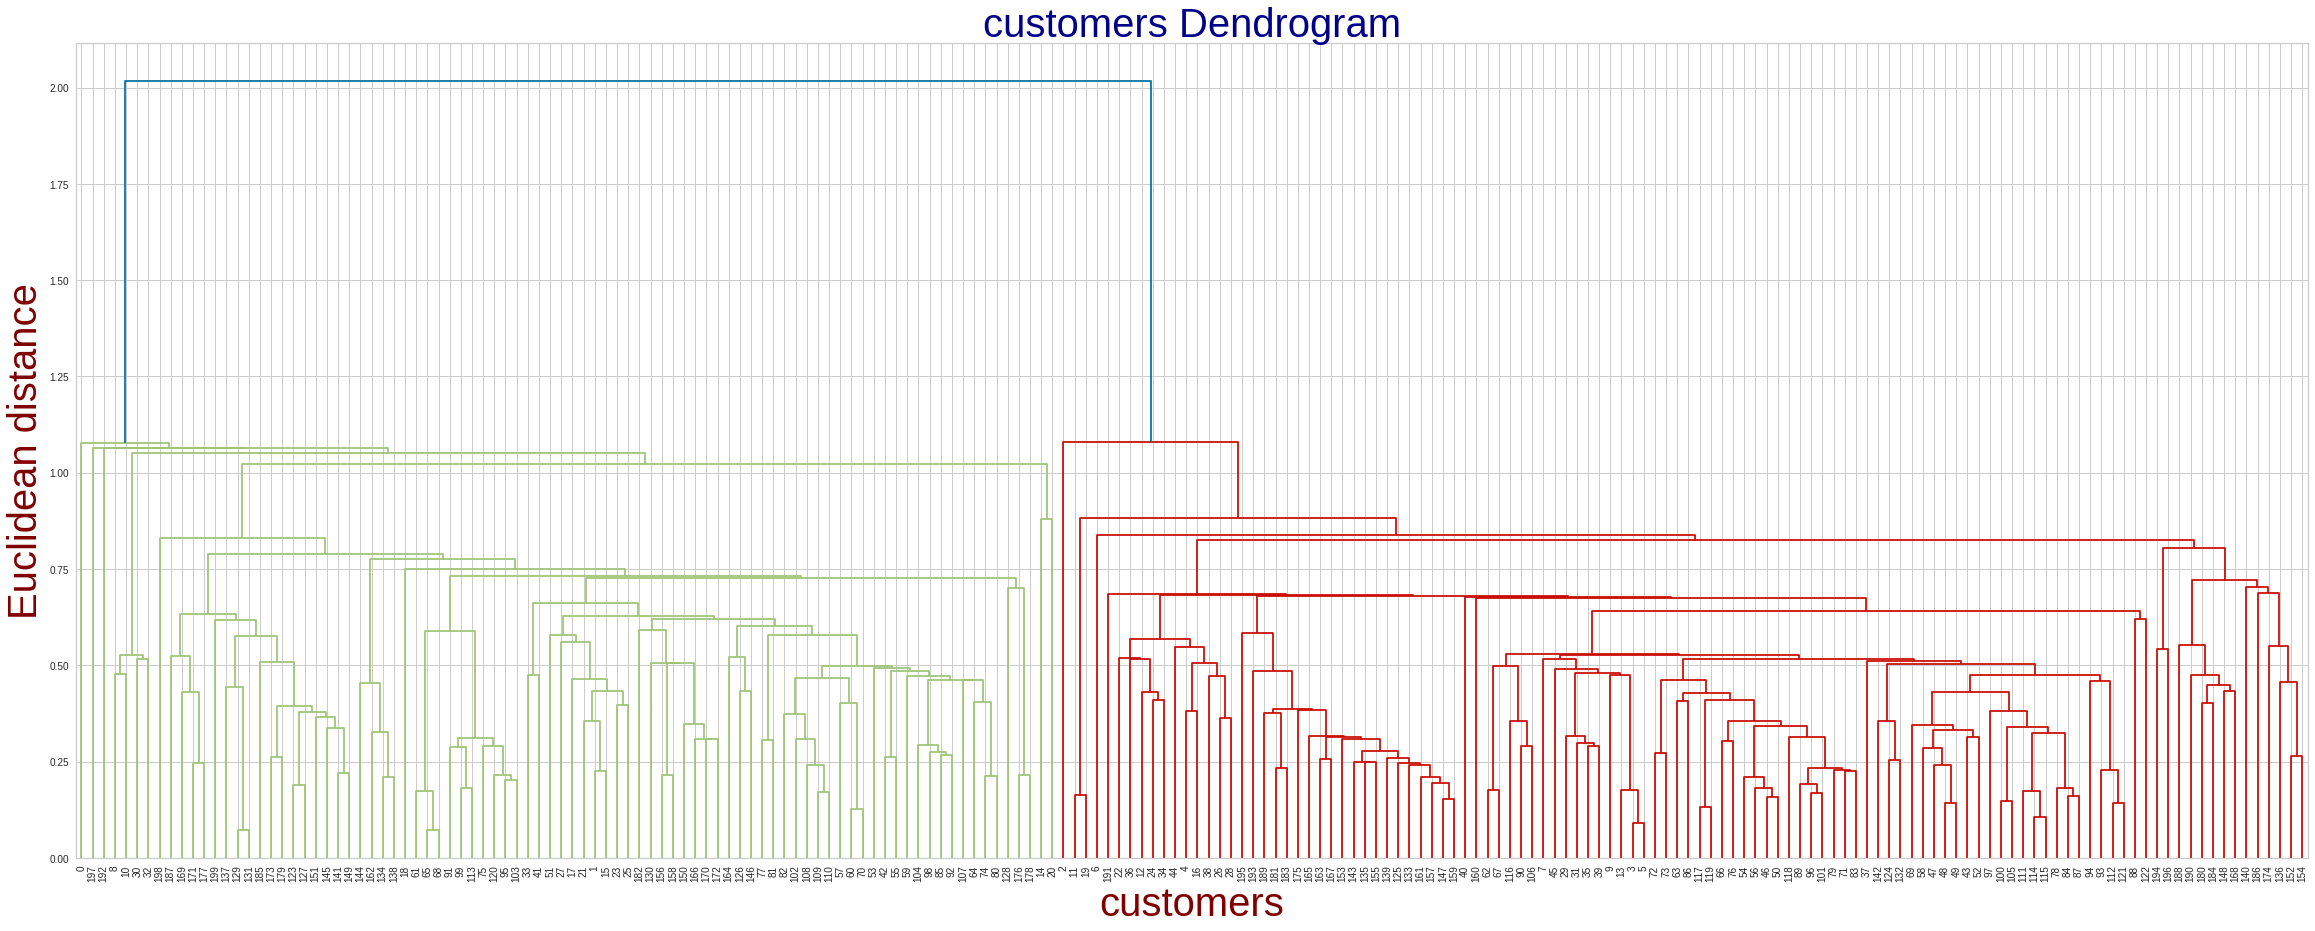

In [50]:
# Plotting Dendogram (hierarchical clustering)
plt.figure(figsize=(40, 15))
dendrogrm = sch.dendrogram(sch.linkage(X,method='single'),labels=Mall_df.index)
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=10)
plt.title('customers Dendrogram',fontsize=40,color = "darkblue")
plt.xlabel('customers',fontsize=40, color = "maroon")
plt.ylabel('Euclidean distance', fontsize=40,color = "maroon")
plt.show()

 The x-axis contains the samples and y-axis represents the distance between these samples. The vertical line with maximum distance is the blue line and hence we can decide a threshold of 12.5 and cut the dendrogram .

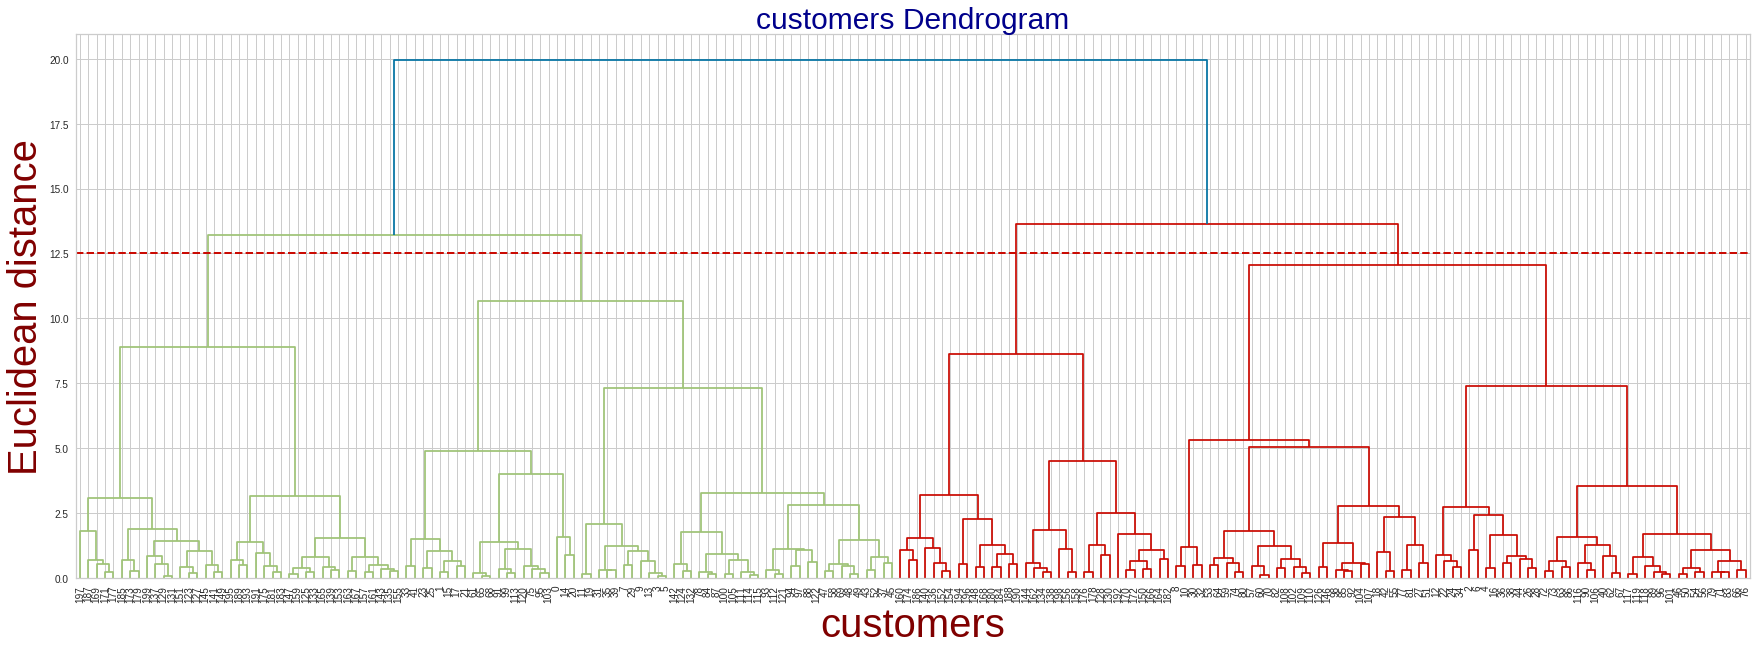

In [51]:
# plotting dendogram with threshold

plt.figure(figsize=(30, 10))
dendrogrm = sch.dendrogram(sch.linkage(X, method = 'ward'),labels=Mall_df.index)
plt.axhline(y = 12.5, color='r', linestyle='--',lw = 2)
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=10)
plt.title('customers Dendrogram',fontsize=30,color = "darkblue")
plt.xlabel('customers',fontsize=40, color = "maroon")
plt.ylabel('Euclidean distance', fontsize=40,color = "maroon")
plt.show()

From the agglomerative hierarchical clustering we get the number of clusters = 4 .

### Model for Agglomerative

In [52]:
# Model Building

from sklearn.cluster import AgglomerativeClustering

agglo_model = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
agglo_model.fit(data_scaled)

AgglomerativeClustering(n_clusters=4)

In [53]:
# calculating labels where k = 4 

labels_2 = agglo_model.labels_

0    69
1    59
3    39
2    33
dtype: int64


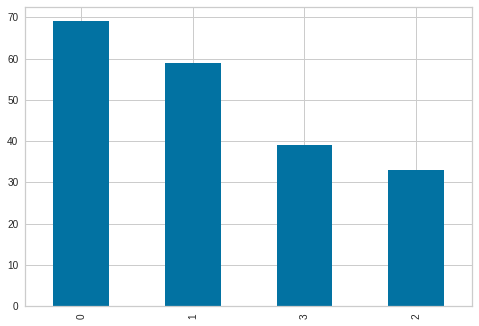

In [54]:
# Number of observations in each cluster
print(pd.Series(agglo_model.labels_).value_counts())
pd.Series(agglo_model.labels_).value_counts().plot( kind= 'bar')
plt.show()

* First cluster we have 69 rows based on their symmetry .
* Second cluster we have 59 rows based on their symmetry .
* Third cluster we have 33 rows based on their symmetry .
* Fourth cluster we have 39 rows based on their symmetry .

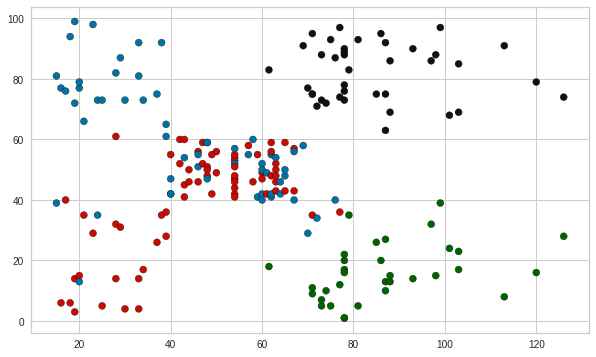

In [55]:
# plotting 4 clusters

color_map={0:'r',1:'b',2:'darkgreen',3:'k'}
label_color=[color_map[l] for l in agglo_model.labels_]
plt.figure(figsize=(10,6))
plt.scatter(s,f, c=label_color ,cmap='Spectral',edgecolors = "black")
plt.show()

In [56]:
# Adding cluster labels with PCA data 
df_pair_plot2 = pd.DataFrame(reduced_data, columns=['PC_' +str(i) for i in range(1,4)])
df_pair_plot2['Cluster2']=agglo_model.labels_
df_pair_plot2.head()

,PC_1,PC_2,PC_3,Cluster2
0,-0.424529,-0.813534,-2.061221,1
1,-1.445420,-0.637185,-2.246739,1
2,0.030119,-2.023548,-0.240160,0
3,-1.714475,-1.723334,-0.557763,1
4,-0.333106,-1.899405,-0.269829,0


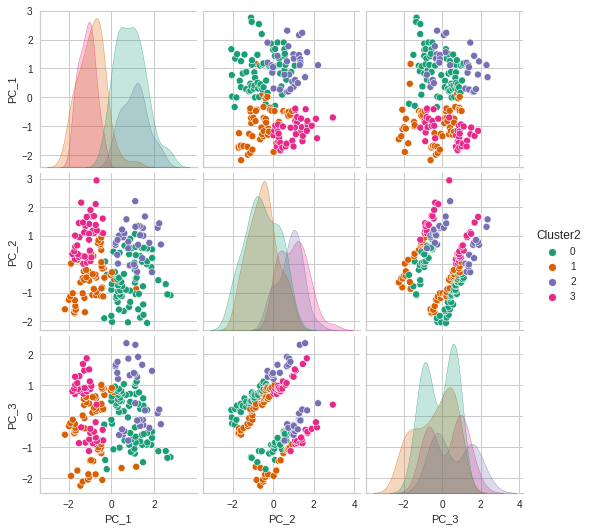

In [57]:
# pair wise relationship of components on the data
sns.pairplot(df_pair_plot2, hue='Cluster2', palette= 'Dark2', diag_kind='kde')
plt.show()

Above pair plot shows,PC2 and PC1 have better sepration of all clusters.

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise) Model

In [58]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors = 5)
nbrs = neigh.fit(data_scaled)

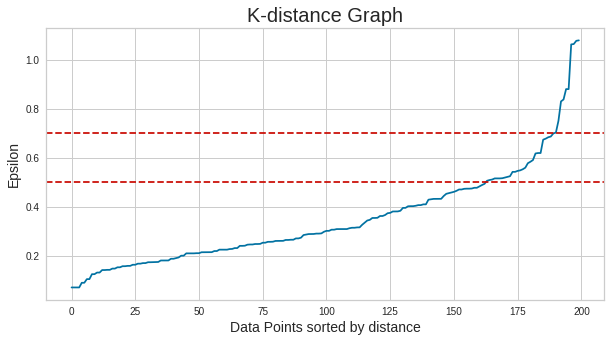

In [59]:
 # Plotting K-distance Graph
distances, indices = nbrs.kneighbors(data_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]


plt.figure(figsize=(10,5))
plt.plot(distances)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axhline(y=0.7, color='r', linestyle='--')
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

 We get the elbow between 0.5 to 0.7 .

In [60]:
for eps in np.arange(0.5,0.7,.1):
  for min_samples in np.arange(2,9):
      clusterer = DBSCAN(eps=eps, min_samples=min_samples)
      cluster_labels = clusterer.fit_predict(data_scaled)
      x= cluster_labels +2
      y = np.bincount(x)
      ii = np.nonzero(y)[0]
      results = list(zip(ii,y[ii]) )
      print(10*"*=*=*=")
      print('\neps=',eps,'| min_samples= ', min_samples, '| obtained clustering: ', results)

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=

eps= 0.5 | min_samples=  2 | obtained clustering:  [(1, 37), (2, 6), (3, 9), (4, 2), (5, 2), (6, 2), (7, 3), (8, 3), (9, 2), (10, 20), (11, 20), (12, 19), (13, 3), (14, 5), (15, 7), (16, 2), (17, 8), (18, 3), (19, 19), (20, 2), (21, 3), (22, 4), (23, 3), (24, 5), (25, 4), (26, 2), (27, 3), (28, 2)]
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=

eps= 0.5 | min_samples=  3 | obtained clustering:  [(1, 53), (2, 9), (3, 6), (4, 3), (5, 3), (6, 19), (7, 20), (8, 20), (9, 3), (10, 5), (11, 7), (12, 8), (13, 19), (14, 3), (15, 3), (16, 4), (17, 4), (18, 3), (19, 5), (20, 3)]
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=

eps= 0.5 | min_samples=  4 | obtained clustering:  [(1, 83), (2, 9), (3, 5), (4, 19), (5, 17), (6, 20), (7, 7), (8, 3), (9, 18), (10, 4), (11, 7), (12, 4), (13, 4)]
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=

eps= 0.5 | min_samples=  5 | obtained clustering:  [(1, 107

When minimum sample = 5 and eps= 0.6 we get the best clusters

### Model foe DBSCAN

In [61]:
# model Creation
dbscan_opt=DBSCAN(eps = 0.6,min_samples=5)
dbscan_opt.fit(data_scaled)

DBSCAN(eps=0.6)

In [62]:
# calculating labels where k = 5 

labels_3 = dbscan_opt.labels_

-1    64
 0    56
 4    21
 7    18
 6    10
 5     9
 8     7
 1     6
 2     5
 3     4
dtype: int64


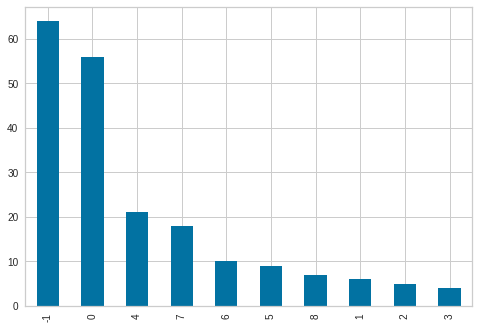

In [63]:
# Number of observations in each cluster
print(pd.Series(dbscan_opt.labels_).value_counts())
pd.Series(dbscan_opt.labels_).value_counts().plot( kind= 'bar')
plt.show()

>[(1, 62), (2, 57), (3, 6), (4, 5), (5, 4), (6, 22), (7, 9), (8, 10), (9, 18), (10, 7)]
* In this list of the tuples the first number represents the cluster number and second represents the number of rows present in thet clusters .Where, the first cluster represents the outliers.

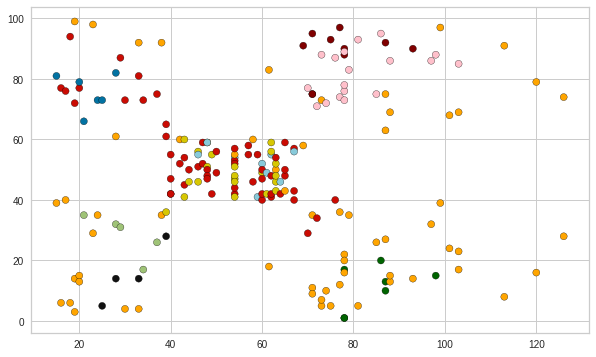

In [64]:
# plotting 10 clusters

color_map={0:'r',1:'b',2:'g',3:'k',0:'r',1:'b',2:'g',3:'k',4:'y',5:'c', 6:'maroon', 7:'pink', 8:'darkgreen', -1:'orange'}
label_color=[color_map[l] for l in dbscan_opt.labels_]
plt.figure(figsize=(10,6))
plt.scatter(s,f, c=label_color ,cmap='Spectral',edgecolors = "black")
plt.show()

In [65]:
# Adding cluster labels with PCA data 
df_pair_plot3 = pd.DataFrame(reduced_data, columns=['PC_' +str(i) for i in range(1,4)])
df_pair_plot3['Cluster3']=dbscan_opt.labels_
df_pair_plot3.head()

,PC_1,PC_2,PC_3,Cluster3
0,-0.424529,-0.813534,-2.061221,-1
1,-1.445420,-0.637185,-2.246739,1
2,0.030119,-2.023548,-0.240160,-1
3,-1.714475,-1.723334,-0.557763,0
4,-0.333106,-1.899405,-0.269829,-1


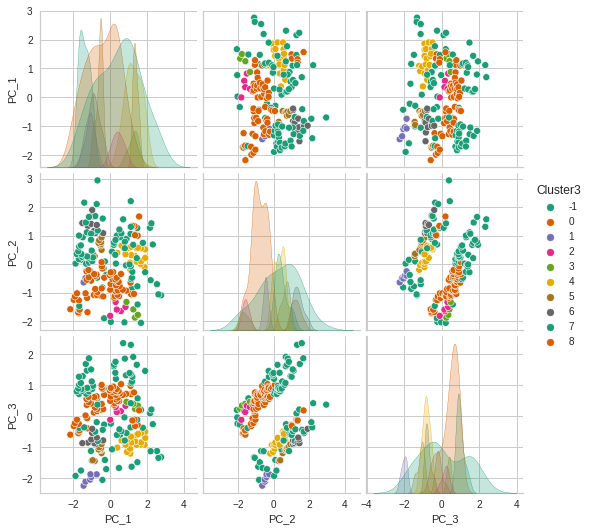

In [66]:
# pair wise relationship of components on the data
sns.pairplot(df_pair_plot3, hue='Cluster3', palette= 'Dark2', diag_kind='kde')
plt.show()

In this pairplot we can see that it is heard to separate the clusters in this DBSCAN clustering . So,we will omit the model .

### Evaluation

In [67]:
# printing the clusters 
print("\n",5*"*","kmean clustering",5*"*")
print(pd.Series(Kmeans_model_1.labels_).value_counts())
print("\n",5*"*","alggo. clustering",5*"*")
print(pd.Series(agglo_model.labels_).value_counts())
print("\n",5*"*","DBSCAN. clustering",5*"*")
print(pd.Series(dbscan_opt.labels_).value_counts())


 ***** kmean clustering *****
1    40
4    39
2    37
3    31
5    30
0    23
dtype: int64

 ***** alggo. clustering *****
0    69
1    59
3    39
2    33
dtype: int64

 ***** DBSCAN. clustering *****
-1    64
 0    56
 4    21
 7    18
 6    10
 5     9
 8     7
 1     6
 2     5
 3     4
dtype: int64


#### Scatter plots for all models

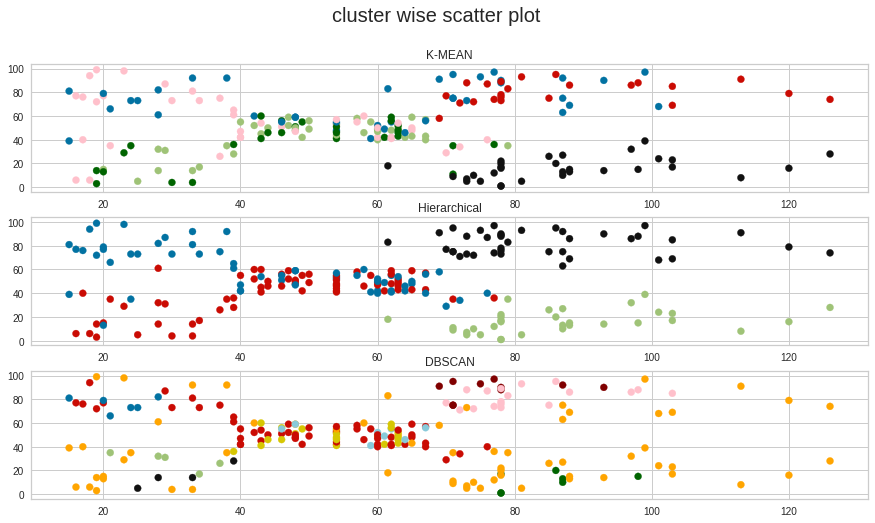

In [68]:
# plotting 4 clusters(K-MEAN)
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,8))
color_map1={0:'r',1:'b',2:'g',3:'k', 4:'pink', 5:'darkgreen',}
label_color1=[color_map1[l] for l in Kmeans_model_1.labels_]
ax1.scatter(s,f, c=label_color1 ,cmap='Spectral')
ax1.set_title("K-MEAN",size=12)

# plotting 4 clusters(hierarchical)
color_map2={0:'r',1:'b',2:'g',3:'k'}
label_color2=[color_map2[l] for l in agglo_model.labels_]
ax2.scatter(s,f, c=label_color2 ,cmap='Spectral')
ax2.set_title("Hierarchical",size=12)

# plotting 10 clusters(DBSCAN)
color_map3 ={0:'r',1:'b',2:'g',3:'k',0:'r',1:'b',2:'g',3:'k',4:'y',5:'c', 6:'maroon', 7:'pink', 8:'darkgreen', -1:'orange'}
label_color3 =[color_map[l] for l in dbscan_opt.labels_]
ax3.scatter(s,f, c=label_color3 ,cmap='Spectral')
ax3.set_title("DBSCAN",size=12)
plt.suptitle("cluster wise scatter plot",size=20)
plt.show()

In [69]:
# number of rows in each cluster(kmean)
a = pd.Series(Kmeans_model_1.labels_).value_counts()

In [70]:
# number of rows in each cluster(Agglomerative)
b = pd.Series(agglo_model.labels_).value_counts()

In [71]:
models = pd.DataFrame({"Clusters_number":["First","Second","Third","Fourth","Fifth","Sixth"],"K_mean":a.values,"Agglomerative":
                       [69, 59, 39, 33,0,0]})

In [72]:
models

,Clusters_number,K_mean,Agglomerative
0,First,40,69
1,Second,39,59
2,Third,37,39
3,Fourth,31,33
4,Fifth,30,0
5,Sixth,23,0


In [73]:
# creating function to plot performance for comparison 

def plot_s(x1,y1,z1,k1):
    
    for bar in x1.patches:
        plt.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width() / 2,bar.get_height())
                     , ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')
    # Setting the label for x-axis
    plt.xlabel(y1, size=14)

    # Setting the label for y-axis
    plt.ylabel(z1, size=20)

    # Setting the title for the graph
    plt.title(k1,size=20)

    # Finally showing the plot
    plt.show()

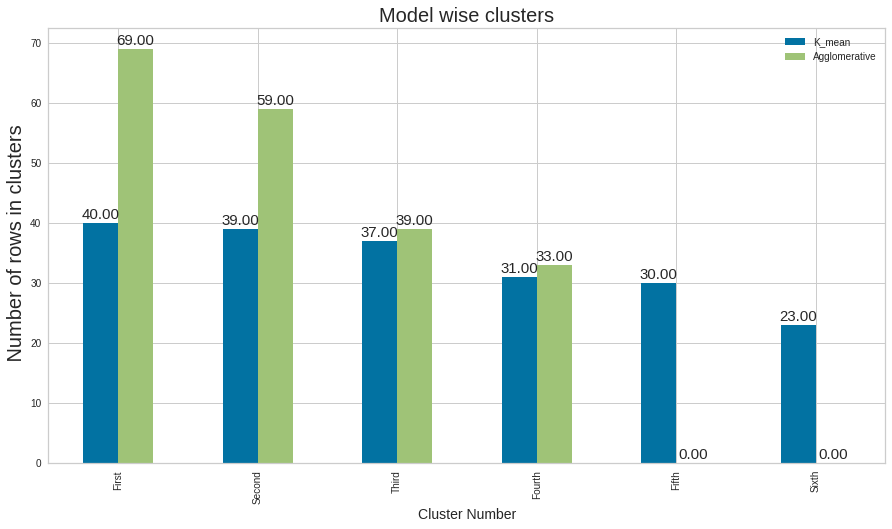

In [74]:
fig,ax1= plt.subplots(1,1,figsize=(15,8)) 
x2=models.plot(x="Clusters_number", y=["K_mean","Agglomerative"], kind="bar",ax=ax1)

plot_s(x2,"Cluster Number"," Number of rows in clusters","Model wise clusters")

### Conclusion
**We can see that in K mean clustering the number of clusters are close than the Hierarchical Clustering and we can also separate the rows as per similarity ,So we consider the k_men clustering as the best model .**
#### So , The k mean clustering is the best model to identify different type of customers .

In [91]:
kk = Mall_df.iloc[:,[2,3]]

In [92]:
# predicting values for k-mean
Kmeans_model = KMeans(n_clusters = 6)
y_km = Kmeans_model.fit_predict(kk) 

In [93]:
 # dataframe for  predicted values
 m = pd.DataFrame({"y_KM":y_km})

In [94]:
# separating index based on clusters
first_index = m[m["y_KM"] == 0].index
second_index = m[m["y_KM"] == 1].index
third_index = m[m["y_KM"] == 2].index
fourth_index = m[m["y_KM"] == 3].index
fifth_index = m[m["y_KM"] == 4].index
sixth_index = m[m["y_KM"] == 5].index

In [95]:
new_data.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

In [96]:
# printing values based on clusters

print(5*"******", "first_cluster",5*"******")
print(new_data.iloc[first_index,[2,3]].head(10))
print(5*"******", "second_cluster",5*"******")
print(new_data.iloc[second_index,[2,3]].head(10))
print(5*"******", "third_cluster",5*"******")
print(new_data.iloc[third_index,[2,3]].head(10))
print(5*"******", "Fourth_cluster",5*"******")
print(new_data.iloc[fourth_index,[2,3]].head(10))
print(5*"******", "Fifth_cluster",5*"******")
print(new_data.iloc[fifth_index,[2,3]].head(10))
print(5*"******", "Sixth_cluster",5*"******")
print(new_data.iloc[sixth_index,[2,3]].head(10))

****************************** first_cluster ******************************
     Annual Income (k$)  Spending Score (1-100)
123                69.0                      91
125                70.0                      77
127                71.0                      95
129                71.0                      75
131                71.0                      75
133                72.0                      71
135                73.0                      88
137                73.0                      73
139                74.0                      72
141                75.0                      93
****************************** second_cluster ******************************
    Annual Income (k$)  Spending Score (1-100)
0                 15.0                      39
2                 16.0                       6
4                 17.0                      40
6                 18.0                       6
8                 19.0                       3
10                19.0               

In [80]:
# describe the data
new_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,200.0,0.440,0.497633,0.0,0.00,0.00,1.00,1.0
Age,200.0,38.850,13.969007,18.0,28.75,36.00,49.00,70.0
Annual Income (k$),200.0,59.805,25.110699,15.0,41.50,61.25,77.25,126.0
Spending Score (1-100),200.0,50.200,25.823522,1.0,34.75,50.00,73.00,99.0


## Observations
#### first_cluster = low anual income,low Spending Score .
#### second_cluster =  medium anual income ,high Spending Score .
#### third_cluster = high anual income , lowest Spending Score .
#### fourth_cluster =  medium anual income , medium Spending Score .
#### fifh_cluster =  low anual income,high Spending Score .
#### sixth_cluster =  high anual income , high Spending Score .

#### Visualize the data based on clusters

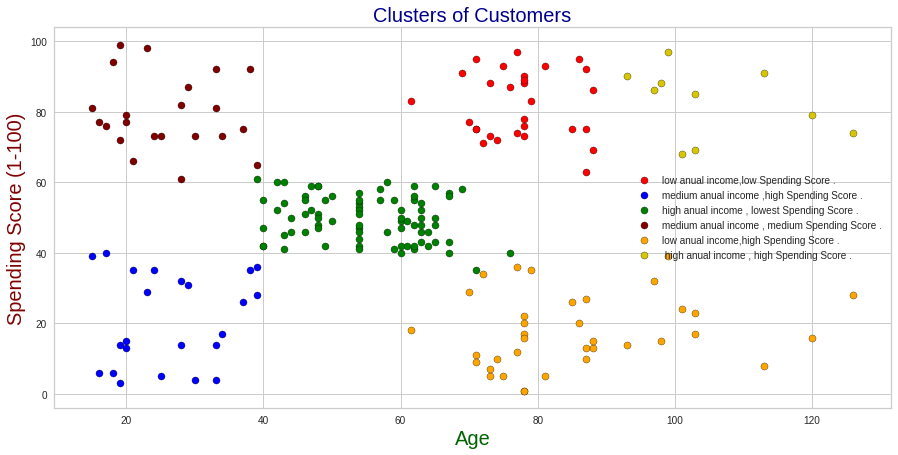

In [97]:
col = new_data.columns
plt.figure(figsize=(15,7))
plt.scatter(new_data.iloc[first_index,2], new_data.iloc[first_index,3], s = 50, c = 'red', label = 'low anual income,low Spending Score .',edgecolors = "black")
plt.scatter(new_data.iloc[second_index, 2], new_data.iloc[second_index, 3], s = 50, c = 'blue', label = 'medium anual income ,high Spending Score .',edgecolors = "black")
plt.scatter(new_data.iloc[third_index, 2], new_data.iloc[third_index, 3], s = 50, c = 'green', label = 'high anual income , lowest Spending Score .',edgecolors = "black")
plt.scatter(new_data.iloc[fourth_index, 2], new_data.iloc[fourth_index, 3], s = 50, c = 'maroon', label = 'medium anual income , medium Spending Score .',edgecolors = "black")
plt.scatter(new_data.iloc[fifth_index, 2], new_data.iloc[fifth_index, 3], s = 50, c = 'orange', label = 'low anual income,high Spending Score .',edgecolors = "black")
plt.scatter(new_data.iloc[sixth_index, 2], new_data.iloc[sixth_index, 3], s = 50, c = 'y', label = ' high anual income , high Spending Score .',edgecolors = "black")
plt.title('Clusters of Customers',fontsize=20,color = "darkblue")
plt.xlabel(col[1],fontsize=20,color = "darkgreen")
plt.ylabel(col[3],fontsize=20,color = "maroon")
plt.legend()
plt.show()

>The buisness conclusition is that the third cluster which has high income but low spending that we can set as our terget customers.

In [87]:
copy_df = Mall_df.copy()

In [88]:
# adding the clusters no to the dataframe
copy_df["Cluster1"] = Kmeans_model.labels_

In [89]:
 hh = copy_df.groupby(by=["Cluster1","Gender"]).mean()

first_cluster = low anual income,low Spending Score . 
second_cluster = medium anual income ,high Spending Score . 
third_cluster = high anual income , lowest Spending Score . 
fourth_cluster = medium anual income , medium Spending Score . 
fifh_cluster = low anual income,high Spending Score . 
sixth_cluster = high anual income , high Spending Score .


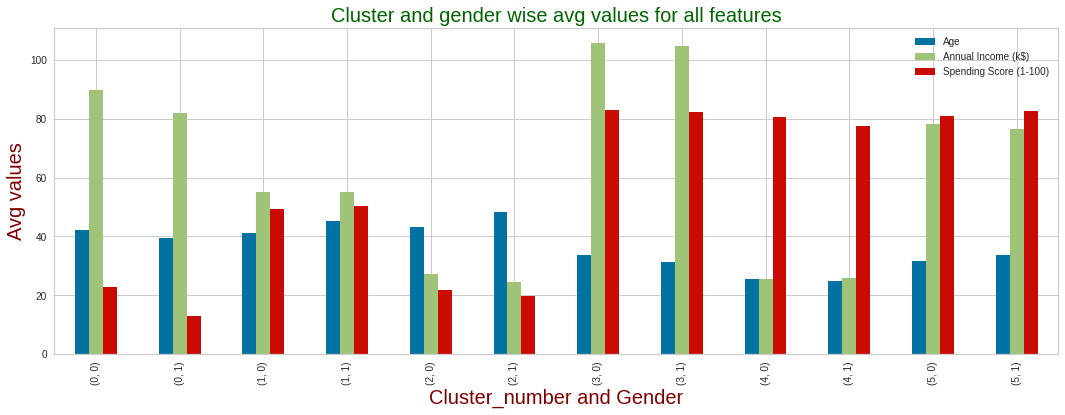

In [90]:
# making the bar chart on the data
fig,ax1 = plt.subplots(1,1,figsize = (18,6))
hh.plot(kind = "bar",ax =ax1)
ax1.set_xlabel("Cluster_number and Gender", size=20,color = "maroon")
ax1.set_ylabel("Avg values", size=20,color = "maroon")
ax1.set_title("Cluster and gender wise avg values for all features", size=20,color = "darkgreen")
print("first_cluster = low anual income,low Spending Score .","\nsecond_cluster = medium anual income ,high Spending Score .",
      "\nthird_cluster = high anual income , lowest Spending Score .","\nfourth_cluster = medium anual income , medium Spending Score .",
      "\nfifh_cluster = low anual income,high Spending Score .","\nsixth_cluster = high anual income , high Spending Score .")
plt.show()

In cluster three maximum number of females have medium anual income and high Spending Score.